In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import balance
import CES

In [2]:
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')
table = tables[14]
key = jax.random.PRNGKey(1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# __I\O - таблицы__

Пусть экономика состоит из $n$ промышленных отраслей, производящие __вторичные ресурсы__ и потребляющая $m$ видов __первичных ресурсов__, так же пусть имеется $l$ __конечных потребителей__, потребляющие вторичные ресурсы. Тогда можно ввести __I/O__-таблицу $\hat{Z}$ размера $(n+m)\times(n+l)$, в ячейках которой записаны потоки товаров из одной отрасли в другую.

Одним из примеров баз данных можно привести $NIOT$, разделяющую экономику на $n=56$ отраслей и $l = 6$ конечных потребителя. Так же в этих таблицах можно выделить $m=3$ первичных ресурса. Так как статистика потребления первичных ресурсов конечными потребителями в некотором смысле плохая, будем считать, что конечные потребители не потребляют первичные рессурсы.

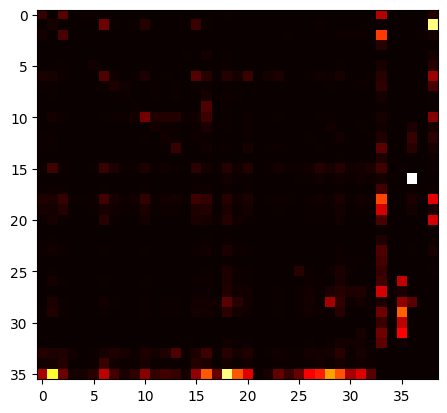

In [3]:
plt.imshow(table, cmap='hot', interpolation='nearest')
plt.show()

# __Производственные Функции__

Рассмотрим модель экономики, называемой __Межотраслевым Балансом__. Неформально ее можно описать как набор производственных функций и потребителей, которые закупаясь по некоторым рыночным ценам и максимизируя полезность\доход воспроизводят(приближенно) __I/O__-таблицы.   Допустимых функций бесконечно много - вопрос в том как такие найти. Хорошим классом является CES. Для любой корректной $\hat{Z}$ и люого $\rho\in\mathbb{R}^{n}_{++}$ существуют веса $W$, что в равновесных ценах пропорции воспроизведутся. Стартанем отсюда.

In [5]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
rho = jax.random.uniform(key, (n,), minval=0.1, maxval = 10)
W = CES.get_W(Z_hat, rho)

Имея на руках производственные функции можно найти равновесные цены, полагая $s$ зафиксированным(и единичным).

In [7]:
cost_f = jax.jit(lambda p: CES.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)
p

Array([0.99999994, 1.0000001 , 0.99999994, 1.0000001 , 1.0000001 ,
       1.        , 1.        , 1.        , 0.9999998 , 0.99999994,
       1.0000001 , 1.0000001 , 1.0000002 , 1.        , 1.        ,
       1.0000001 , 1.0000002 , 1.0000001 , 0.9999999 , 1.        ,
       1.        , 0.9999999 , 1.0000004 , 1.        , 0.99999994,
       1.        , 1.0000001 , 1.        , 0.9999999 , 1.000001  ,
       1.        , 0.9999996 , 1.0000002 , 1.        , 1.        ,
       1.        ], dtype=float32)

Имея равновесные цены $p$ можно рассчитать и пропорции потребления. Важно заметить, что это именно пропорции, а не точное воспроизведение.
В дальнейшем мы будем так же и масштабировать, чтоб получить функцию ошибки, и ее дифференциировать. Как видно они похожи, но не 1 в 1
(а разве не должны быть 1 в 1?)

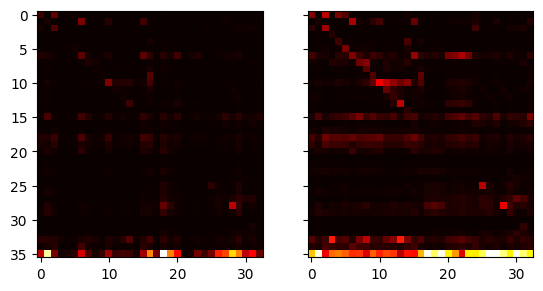

In [8]:
Z = CES.JCES(p, W, rho)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(Z_hat, cmap='hot', interpolation='nearest')
ax2.imshow(Z, cmap='hot', interpolation='nearest')

In [9]:
jnp.sum(jnp.abs(Z_hat - Z))/jnp.sum(Z_hat)

Array(0.99999017, dtype=float32)

Подгоним масштабирующие коэффициенты так, чтоб из пропорций потребления получились наиболее приближенными к данным. Для этого можно положить вектор конечного потребления известным, тогда задача будет иметь аналитическое решение. Хотя теперь над тем, чтоб взять градиент по ошибке придется постараться.

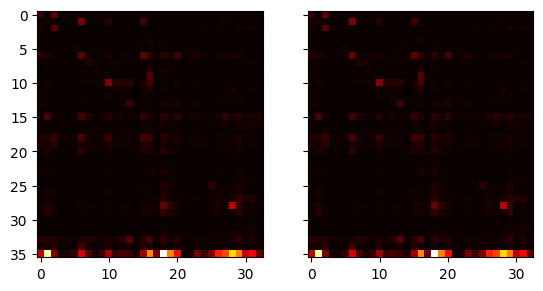

In [11]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
Z0_hat = jnp.sum(table[:n,n:], axis = 1)
rho = jax.random.uniform(key, (n,), minval=0.1, maxval = 10)
W = CES.get_W(Z_hat, rho)
cost_f = jax.jit(lambda p: CES.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)
Z = CES.JCES(p, W, rho)
y = jnp.linalg.inv(jnp.diag(jnp.sum(Z, axis = 0)) - Z[:n,:]) @ Z0_hat # это гораздо лучше чем оптимизационный слой
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(Z_hat, cmap='hot', interpolation='nearest')
ax2.imshow(Z * y, cmap='hot', interpolation='nearest')

In [12]:
jnp.sum(jnp.abs(Z_hat - Z * y))/jnp.sum(Z_hat)

Array(0.00011652, dtype=float32)

Т.е наконец-то веса считаются эффективно. Осталось научиться делать обратное распростронение ошибки, и тогда можно будет применять методы машинного обучения для воспроизведения экономики. Нужно сделать все по стандартам, чтоб легко можно было прикрутить цены на производственные мощности или члены для конечных потребителей. 

# Модель Машинного Обучения

Одной из возникших задач является отыскание таких параметров $W,\rho$, что по паре $(s, \hat{Z}_{0})$ можно было предсказать матрицу промежуточного потребления $Z$ наиболее приближенную к реальной матрице промежуточного потребления $\hat{Z}$. Такие коэффициенты можно подобрать используя методы машинного обучения.